In [1]:
!pip install sentence_transformers==0.3.8 
!pip install umap-learn==0.4.6 

In [2]:
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from string import punctuation

from collections import Counter
from collections import OrderedDict

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
PATH      = "drive/MyDrive/Colab Notebooks/IRTG/Smart_contracts_paper/USC/SC-topics-unlabelled/"
DATA_PATH = "drive/MyDrive/Colab Notebooks/IRTG/Smart_contracts_paper/USC/SC-open-source-source-code-scraping/data"

In [4]:
df = pd.read_csv(f"{DATA_PATH}/open_source_parsed_16thousand.csv")
df.comments.fillna('empty', inplace=True)

In [5]:
df.shape

(16250, 5)

In [6]:
# remove thouse without comments
df.comments.fillna('empty', inplace=True)
df.loc[df.comments.apply(lambda x : x.isspace()), 'comments'] = 'empty'
df.comments = df.comments.str.replace('_','')
df.loc[df.comments.apply(len)<10,'comments'] = 'empty'
df.loc[df.comments.apply(lambda x: len(x.split()))<5,'comments'] = 'empty'
df.comments = df.comments.str.replace('[^a-zA-Z]',' ').str.replace('[ ]{2,}', ' ', regex=True)
df = df[df.comments!='empty']
df.reset_index(drop=True, inplace=True)

In [7]:
df.shape

(13563, 5)

Code based on the blogpost https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6


In [8]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df.comments, show_progress_bar=True)

In [9]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine', random_state=42).fit_transform(embeddings)

In [10]:
km_silhouette = []
km_db = []
n_clusters = [*range(3,50)]

In [11]:
for i in n_clusters:
    cluster = KMeans(n_clusters=i,          
                    random_state=42).fit(umap_embeddings)
    
    preds = cluster.predict(umap_embeddings)
    
    s_score = silhouette_score(umap_embeddings, preds)
    db_score = davies_bouldin_score(umap_embeddings, preds)

    km_silhouette.append(s_score)
    km_db.append(db_score)

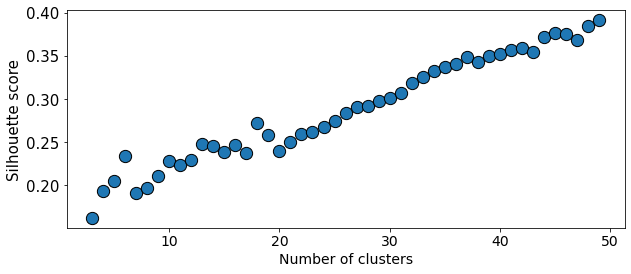

In [12]:
plt.figure(figsize=(10,4))
#plt.title("The Silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in n_clusters], y=km_silhouette, s=150, edgecolor='k')
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette score", fontsize=15)
plt.xticks([10, 20, 30, 40, 50], fontsize=14)
plt.yticks(fontsize=15)
#plt.show()
plt.savefig(f"{PATH}/images/silhouette_unlabelled_t.png", transparent=True)

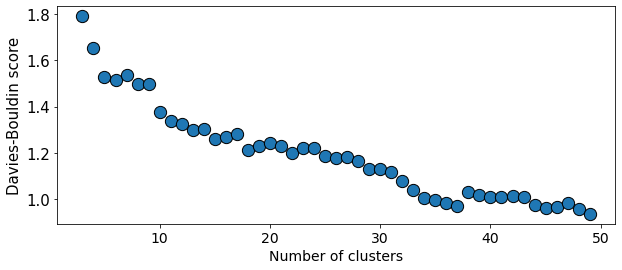

In [13]:
plt.figure(figsize=(10,4))
#plt.title("The Davies-Bouldin score \nfor determining number of clusters\n", fontsize=16)
plt.scatter(x=[i for i in n_clusters], y=km_db, s=150, edgecolor='k')
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Davies-Bouldin score", fontsize=15)
plt.xticks([10, 20, 30, 40, 50], fontsize=14)
plt.yticks(fontsize=15)
#plt.show()
plt.savefig(f"{PATH}/images/davies_unlabelled_t.png", transparent=True)

In [14]:
cluster = KMeans(n_clusters=12,          
                    random_state=42).fit(umap_embeddings)

In [15]:
color_map = {0: 'tab:blue',
             1: 'tab:orange',
             2: 'tab:green',
             3: 'tab:red',
             4: 'tab:purple',
             5: 'tab:brown',
             6: 'tab:pink',
             7: 'tab:gray',
             8: 'tab:olive',
             9: 'tab:cyan',
             10: 'navy',
             11: 'blueviolet',
             12: 'salmon',
             13: 'mediumseagreen'} 

7     105
11     97
1      95
6      77
0      76
8      72
2      66
3      52
5      49
4      44
13     36
12     29
10     26
9      15

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


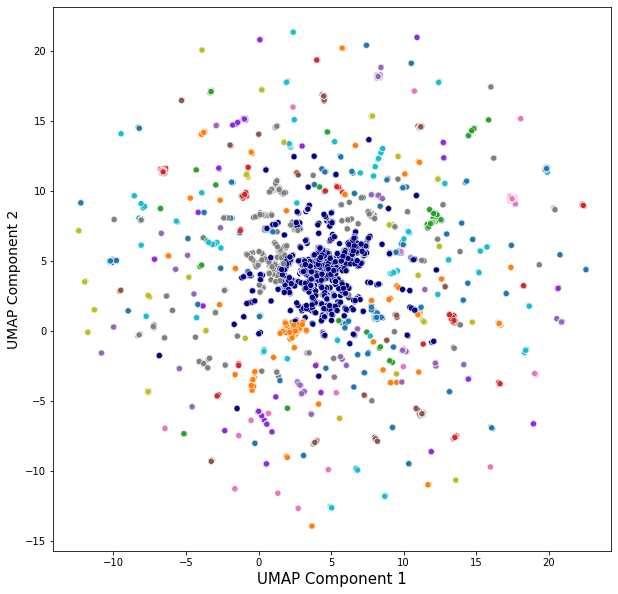

In [16]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(result.x, result.y, c=result.labels.map(color_map))
plt.xlabel("UMAP Component 1", fontsize=15)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.savefig(f"{PATH}/images/scatter_unlabelled_t.png", transparent=True)

In [17]:
result['labels'].value_counts()

10    3598
7     1737
0     1444
1     1130
9      995
5      865
3      812
8      723
4      686
2      534
6      533
11     506
Name: labels, dtype: int64

In [18]:
docs_df = pd.DataFrame(df, columns=["comments"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'comments': ' '.join})

In [19]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.comments.values, m=len(df))

In [20]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

In [21]:
result

,x,y,labels
0,6.581948,6.614092,10
1,9.217912,-2.265576,2
2,7.200544,1.407010,10
3,5.313378,3.526909,10
4,7.297956,-3.009639,0
...,...,...,...
13558,-6.572700,11.350116,3
13559,1.593732,4.369450,10
13560,14.686440,14.292944,2
13561,4.286595,5.229537,10


In [22]:
df[['Umap_x', 'Umap_y', 'label']] = result
df.to_csv(f'{PATH}data/unlabelled_withclusterlabels.csv', index=False)

In [23]:
df[['comments', 'label']]

,comments,label
0,fairwin me fairwin me,10
1,Copyright C zapper nodar suhail seb sumit apo...,2
2,File contracts Roles sol title Roles dev Libr...,10
3,title ChainValidator interface author Jakub F...,10
4,title ERC interface dev see https github com ...,0
...,...,...
13558,dev Wrappers over Solidity s arithmetic opera...,3
13559,TurnCoinERC SecurityToken contract will be up...,10
13560,Copyright C Zerion Inc https zerion io This p...,2
13561,ASTOX token contract Deployed to x Af c e B d...,10


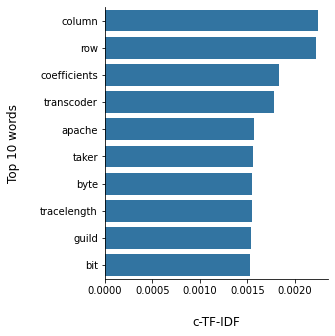

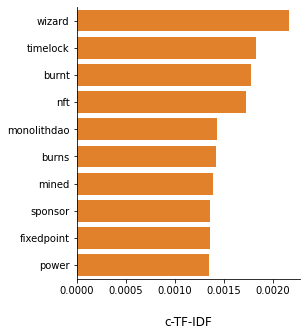

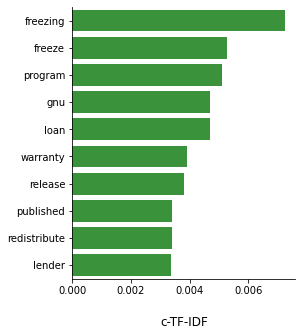

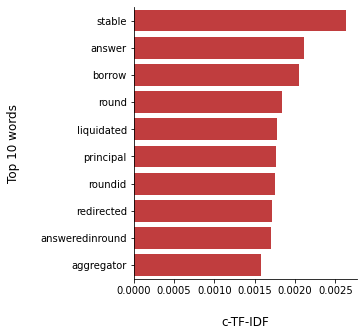

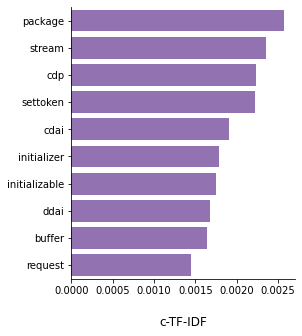

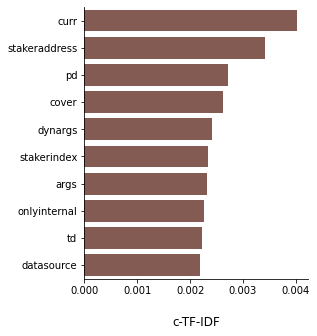

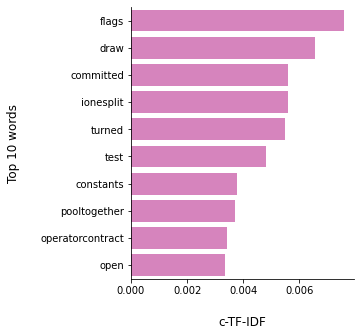

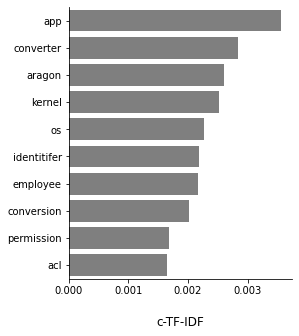

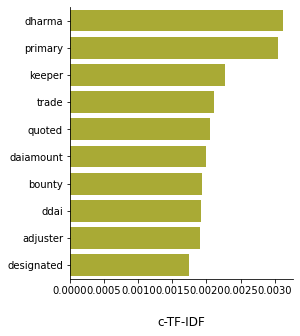

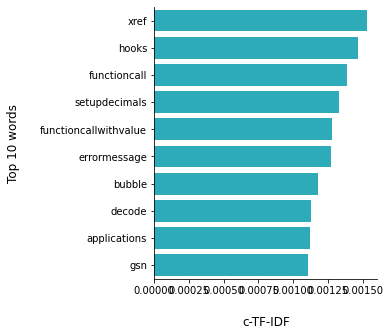

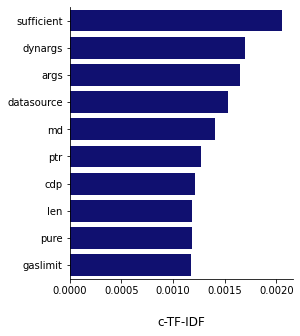

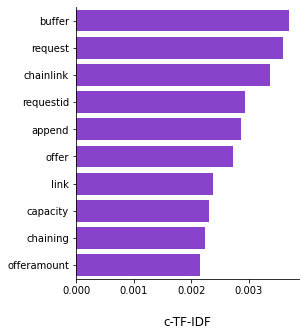

In [24]:
for i in range(12):
  temp_df = pd.DataFrame(top_n_words[i])
  temp_df.sort_values(1, ascending=True, inplace=True)
  fig, ax = plt.subplots(figsize=(4, 5))
  sns_plot = sns.barplot(x=1, y=0, data=temp_df, color=color_map[i], ax=ax)
  sns.despine()

  # Set y-axis label
  if i in [0, 3, 6, 9, 12]: 
    ax.set_ylabel("Top 10 words", labelpad=20, size=12)
  else:
    ax.set_ylabel("", labelpad=20, size=12)
  ax.set_ylim(-0.5, 9.5)
  ax.set_xlabel("c-TF-IDF", labelpad=20, size=12)
  sns_plot.figure.savefig(f"{PATH}/images/Topic_{i}_t.png", bbox_inches = "tight", transparent=True)